In [13]:
#Neeraav Ranjit RNJNEE001
#Assignment 3

In [40]:
import re
#q1 cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [78]:
#Q1 loading dataset
def load_masakhanews(language: str, dataset_root: str = ""):

    lang = language.strip().lower()
    code = "eng" if lang == "eng" else "xho"  

    def read_split(split):
        path = f"{dataset_root}{code}/{split}.tsv"
        return pd.read_csv(path, sep="\t")

    train_df = read_split("train")
    dev_df   = read_split("dev")
    test_df  = read_split("test")

    #combine the headline and the text, then use the cleaner method on it
    for df in (train_df, dev_df, test_df):
        combined = (df["headline"].fillna("") + " " + df["text"].fillna("")).astype(str)
        df["clean_text"] = combined.apply(clean_text)

    # get all unique labels across splits
    labels = sorted(set(train_df["category"]) | set(dev_df["category"]) | set(test_df["category"]))

    # setting a stopward so that we can use it later in the vectorizer
    stopword_lang = "english" if code == "eng" else None

    return train_df, dev_df, test_df, labels, stopword_lang


In [79]:
#just testing that this dataset can load correctly with shape
train_en, dev_en, test_en, labels_en, sw_en = load_masakhanews("eng")
train_xh, dev_xh, test_xh, labels_xh, sw_xh = load_masakhanews("xhosa")

def report_shapes(lang, train_df, dev_df, test_df, labels, stopwords, text_col="clean_text", label_col="category"):
    print(f"\n=== {lang} ===")
    print(f"Labels ({len(labels)}): {labels}")
    print(f"Stopwords: {stopwords}")
    print(f"Train shape: {train_df.shape[0]} rows × {train_df.shape[1]} cols")
    print(f"Dev   shape: {dev_df.shape[0]} rows × {dev_df.shape[1]} cols")
    print(f"Test  shape: {test_df.shape[0]} rows × {test_df.shape[1]} cols")
    if text_col in train_df and label_col in train_df:
        print(f"Sample text col: '{text_col}' | label col: '{label_col}'")
    else:
        missing = [c for c in (text_col, label_col) if c not in train_df.columns]
        print(f"Missing in train_df: {missing}")

report_shapes("English",  train_en, dev_en, test_en, labels_en, sw_en)
report_shapes("isiXhosa", train_xh, dev_xh, test_xh, labels_xh, sw_xh)



=== English ===
Labels (6): ['business', 'entertainment', 'health', 'politics', 'sports', 'technology']
Stopwords: english
Train shape: 3309 rows × 5 cols
Dev   shape: 472 rows × 5 cols
Test  shape: 948 rows × 5 cols
Sample text col: 'clean_text' | label col: 'category'

=== isiXhosa ===
Labels (5): ['business', 'entertainment', 'health', 'politics', 'sports']
Stopwords: None
Train shape: 1032 rows × 5 cols
Dev   shape: 147 rows × 5 cols
Test  shape: 297 rows × 5 cols
Sample text col: 'clean_text' | label col: 'category'


In [52]:
# Question 5 Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

def get_bow_features(train_texts, dev_texts, test_texts, max_features=10000, language='eng'):

    vectorizer = CountVectorizer(
        max_features=max_features,
        stop_words=language if language != 'xhosa' else None,
        lowercase=True
    )
    
    # Fit on training text only
    X_train = vectorizer.fit_transform(train_texts)
    X_dev   = vectorizer.transform(dev_texts)
    X_test  = vectorizer.transform(test_texts)
    
    return X_train, X_dev, X_test, vectorizer



In [44]:
#Question 5 Bag of Words Binary
from sklearn.feature_extraction.text import CountVectorizer

def get_bow_binary_features(train_texts, dev_texts, test_texts, max_features=10000, language='eng'):

    vectorizer = CountVectorizer(
        binary=True,                        # for binary presence/absence
        max_features=max_features,
        stop_words=language if language != 'xhosa' else None,
        lowercase=True
    )
    
    X_train = vectorizer.fit_transform(train_texts)
    X_dev   = vectorizer.transform(dev_texts)
    X_test  = vectorizer.transform(test_texts)
    
    return X_train, X_dev, X_test, vectorizer


In [45]:
#Question 5 TF-IDF
#literallt just took this frmo the docs
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_features(
    train_texts,
    dev_texts,
    test_texts,
    max_features=20000,
    language='eng',
    ngram_range=(1,1),
    min_df=1,
    max_df=1.0,
    sublinear_tf=True,
    norm='l2'):

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words=language if language != 'xhosa' else None,
        lowercase=True,
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=sublinear_tf,
        norm=norm
    )

    X_train = vectorizer.fit_transform(train_texts)
    X_dev   = vectorizer.transform(dev_texts)
    X_test  = vectorizer.transform(test_texts)
    return X_train, X_dev, X_test, vectorizer


In [46]:
#Question 5 unified feature extraction function
from sklearn.preprocessing import LabelEncoder

def extract_features(
    train_df,
    dev_df,
    test_df,
    text_col='clean_text',
    label_col='label',           
    method='bow',                # 'bow' | 'bow_binary' | 'tfidf'
    language='eng',          # None or 'eng'; use None for isiXhosa
    encode_labels=False,         # return int labels + encoder
    **kwargs                     # passed to the underlying vectorizer helper
):

    # sanity checks
    for name, df in [('train_df', train_df), ('dev_df', dev_df), ('test_df', test_df)]:
        if text_col not in df.columns:
            raise KeyError(f"{name} missing text_col='{text_col}'")
        if label_col not in df.columns:
            raise KeyError(f"{name} missing label_col='{label_col}'")

    train_texts = train_df[text_col].astype(str)
    dev_texts   = dev_df[text_col].astype(str)
    test_texts  = test_df[text_col].astype(str)

    #vectorization method selection
    if method == 'bow':
        X_train, X_dev, X_test, vectorizer = get_bow_features(
            train_texts, dev_texts, test_texts, language=language, **kwargs
        )
    elif method == 'bow_binary':
        X_train, X_dev, X_test, vectorizer = get_bow_binary_features(
            train_texts, dev_texts, test_texts, language=language, **kwargs
        )
    elif method == 'tfidf':
        X_train, X_dev, X_test, vectorizer = get_tfidf_features(
            train_texts, dev_texts, test_texts, language=language, **kwargs
        )
    else:
        raise ValueError("Invalid method. Choose 'bow', 'bow_binary', or 'tfidf'.")

    # Labels
    y_train = train_df[label_col].copy()
    y_dev   = dev_df[label_col].copy()
    y_test  = test_df[label_col].copy()

    #maps to labels to encoded integers
    if encode_labels:
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_dev   = le.transform(y_dev)
        y_test  = le.transform(y_test)
        return X_train, X_dev, X_test, y_train, y_dev, y_test, vectorizer, le

    return X_train, X_dev, X_test, y_train, y_dev, y_test, vectorizer


In [55]:
#Question 2
#literally taken frmo the tut
import torch
import torch.nn as nn

class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, X: torch.Tensor):
        return self.linear(X)

    @torch.no_grad()
    def compute_probabilities(self, X):
        return torch.softmax(self.forward(X), dim=1)

    @torch.no_grad()
    def predict(self, X):
        return self.compute_probabilities(X).argmax(dim=1)


In [56]:
#Question 3, helpers for the training method
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

#turn numpy array into tensors
def to_tensors(X, y, device="cpu"):

    #turn into numpy arrays first if sparse
    X_np = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
    y_np = np.asarray(y)
    
    X_t = torch.tensor(X_np, dtype=torch.float32, device=device)
    y_t = torch.tensor(y_np, dtype=torch.long, device=device)
    return X_t, y_t

#make the tensors into loaders to go into the model
def make_loaders(Xtr_t, ytr_t, Xva_t=None, yva_t=None, batch_size=256):
    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True)
    return train_loader, val_loader


#Question 3 training loop
def train_simple(model, train_loader, val_loader=None, *, epochs=30, lr=1e-2, weight_decay=0.0, patience=5, verbose=True):
    #Loss function for multi-class classification. It expects raw logits (no softmax) and integer targets (torch.long).
    crit = nn.CrossEntropyLoss()
    #adds L2 regularization.
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    #config tracking and stopping condiitons
    best_state, best_val = None, -1.0
    no_improve = 0

    for ep in range(1, epochs+1):
        # train
        model.train()
        tot, correct, loss_sum = 0, 0, 0.0
        #iterate over the batches
        for Xb, yb in train_loader:
            #clear gradients, forward pass, compute loss, backward pass, update weights
            opt.zero_grad()
            logits = model(Xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

            loss_sum += loss.item() * yb.size(0)
            correct  += (logits.argmax(1) == yb).sum().item()
            tot      += yb.size(0)

        #self explanatoey
        train_loss, train_acc = loss_sum/tot, correct/tot

        # validate (if val_loader is given)
        if val_loader is None:
            if verbose: print(f"Epoch {ep:02d} | train loss {train_loss:.4f} acc {train_acc:.4f}")
            continue

        model.eval()
        v_tot, v_correct, v_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                logits = model(Xb)
                v_loss_sum += crit(logits, yb).item() * yb.size(0)
                v_correct  += (logits.argmax(1) == yb).sum().item()
                v_tot      += yb.size(0)
        val_loss, val_acc = v_loss_sum/v_tot, v_correct/v_tot

        if verbose:
            print(f"Epoch {ep:02d} | train {train_loss:.4f}/{train_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f}")

        # basic early stopping from last assignment
        if val_acc > best_val:
            best_val   = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose: print(f"Early stopping (patience={patience}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)


In [58]:
#quick test run
device = "cuda" if torch.cuda.is_available() else "cpu"

#vectorize
Xtr, Xdv, Xte, ytr, ydv, yte, vec, le = extract_features(
    train_en, dev_en, test_en,
    text_col="clean_text", label_col="category",
    method="bow", language=sw_en, encode_labels=True, max_features=10000
)

##load tensors
Xtr_t, ytr_t = to_tensors(Xtr, ytr, device=device)
Xdv_t, ydv_t = to_tensors(Xdv, ydv, device=device)

#put tensors into loaders
train_loader, val_loader = make_loaders(Xtr_t, ytr_t, Xdv_t, ydv_t, batch_size=256)

# create model
model = MultinomialLogisticRegression(input_dim=Xtr.shape[1], num_classes=len(le.classes_))

# Train model with random config
train_simple(model, train_loader, val_loader, epochs=30, lr=1e-2, weight_decay=1e-4, patience=5)

#Quick test accuracy
with torch.no_grad():
    Xte_t, yte_t = to_tensors(Xte, yte, device=device)
    preds = model.predict(Xte_t).cpu().numpy()
    print("Test accuracy:", (preds == yte).mean())


Epoch 01 | train 0.7136/0.7800 | val 0.3723/0.8983
Epoch 02 | train 0.1248/0.9755 | val 0.3253/0.9110
Epoch 03 | train 0.0510/0.9967 | val 0.3416/0.9068
Epoch 04 | train 0.0330/0.9982 | val 0.3333/0.9047
Epoch 05 | train 0.0242/0.9994 | val 0.3284/0.9131
Epoch 06 | train 0.0195/0.9994 | val 0.3293/0.9153
Epoch 07 | train 0.0165/1.0000 | val 0.3294/0.9153
Epoch 08 | train 0.0143/1.0000 | val 0.3306/0.9131
Epoch 09 | train 0.0127/1.0000 | val 0.3312/0.9153
Epoch 10 | train 0.0115/1.0000 | val 0.3318/0.9174
Epoch 11 | train 0.0105/1.0000 | val 0.3326/0.9153
Epoch 12 | train 0.0098/1.0000 | val 0.3334/0.9131
Epoch 13 | train 0.0091/1.0000 | val 0.3348/0.9131
Epoch 14 | train 0.0086/1.0000 | val 0.3351/0.9110
Epoch 15 | train 0.0081/1.0000 | val 0.3368/0.9110
Early stopping (patience=5).
Test accuracy: 0.8934599156118144


In [64]:
#grid search for paramater tuning
import numpy as np
import torch

# 1) Small helper: accuracy on a whole split (batched)
@torch.no_grad()
def split_accuracy(model, X_t, y_t, batch_size=1024):
    model.eval()
    n = X_t.size(0)
    correct = 0
    for i in range(0, n, batch_size):
        xb = X_t[i:i+batch_size]
        yb = y_t[i:i+batch_size]
        preds = model.predict(xb)
        correct += (preds == yb).sum().item()
    return correct / n


In [ ]:
import numpy as np
import pandas as pd
import torch

# Assumes you already have these in your codebase:
# - extract_features(train_df, dev_df, test_df, text_col, label_col, method, language, encode_labels, **vec_kwargs)
# - to_tensors(X, y, device)
# - MultinomialLogisticRegression(n_features, n_classes)
# - make_loaders(Xtr_t, ytr_t, Xdv_t, ydv_t, batch_size)
# - train_simple(model, train_loader, val_loader, epochs, lr, weight_decay, patience, verbose=False)
# - split_accuracy(model, Xdv_t, ydv_t)

def tune_all_methods(
    lang_name, train_df, dev_df, test_df, stopwords, *,
    device=None, seed=42, verbose=True
):
    """
    Runs vectorization + LR/BatchSize grid search for multiple methods (BoW, BoW-binary, TF-IDF)
    chosen based on the language. Returns:
      - all_results_df: every LR×BS trial across all methods
      - summary_df: best LR×BS per method
      - best_artifacts: dict[method_name] = {
            'model': best_model,
            'vectorizer': vec,
            'label_encoder': le,
            'config': {'lr', 'batch_size', 'epochs', 'weight_decay', 'method'}
        }
    """

    torch_device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

    # 1) Define per-language method grids (vectorizer kwargs + tuning ranges)
    if str(lang_name).lower().startswith("isi"):  # isiXhosa defaults
        method_specs = [
            ("BoW",        "bow",        {"max_features": 10000},
             {"lrs": (1e-3, 3e-3, 1e-2), "batch_sizes": (64,128,256), "epochs": 40, "weight_decay": 0.0, "patience": 6}),
            ("BoW-binary", "bow_binary", {"max_features": 10000},
             {"lrs": (1e-3, 3e-3, 1e-2), "batch_sizes": (64,128,256), "epochs": 40, "weight_decay": 0.0, "patience": 6}),
            ("TF-IDF",     "tfidf",      {"max_features": 20000, "ngram_range": (1,2), "min_df": 2, "max_df": 0.9},
             {"lrs": (1e-3, 3e-3, 1e-2), "batch_sizes": (64,128,256), "epochs": 40, "weight_decay": 0.0, "patience": 6}),
        ]
    else:  # English defaults
        method_specs = [
            ("BoW",        "bow",        {"max_features": 10000},
             {"lrs": (3e-3, 1e-2, 3e-2), "batch_sizes": (64,128,256,512), "epochs": 30, "weight_decay": 1e-4, "patience": 5}),
            ("BoW-binary", "bow_binary", {"max_features": 10000},
             {"lrs": (3e-3, 1e-2, 3e-2), "batch_sizes": (64,128,256,512), "epochs": 30, "weight_decay": 1e-4, "patience": 5}),
            ("TF-IDF",     "tfidf",      {"max_features": 20000, "ngram_range": (1,2), "min_df": 2, "max_df": 0.9},
             {"lrs": (3e-3, 1e-2, 3e-2), "batch_sizes": (64,128,256,512), "epochs": 30, "weight_decay": 1e-4, "patience": 5}),
        ]

    all_results = []      # list of DataFrames for each method’s trials
    best_rows = []        # for the summary table (best per method)
    best_artifacts = {}   # store best (model, vec, le, config) per method

    # 2) Iterate over each method spec
    for method_name, method_key, vec_kwargs, tune_kwargs in method_specs:

        # 2.1) Vectorize for this method
        Xtr, Xdv, Xte, ytr, ydv, yte, vec, le = extract_features(
            train_df, dev_df, test_df,
            text_col="clean_text", label_col="category",
            method=method_key, language=stopwords, encode_labels=True, **vec_kwargs
        )
        n_features, n_classes = Xtr.shape[1], len(le.classes_)

        # 2.2) Prepare tensors
        Xtr_t, ytr_t = to_tensors(Xtr, ytr, device=torch_device)
        Xdv_t, ydv_t = to_tensors(Xdv, ydv, device=torch_device)

        # 2.3) Grid search over learning rate and batch size
        rows = []
        best_acc = -1.0
        best_state = None
        best_cfg = None

        for lr in tune_kwargs["lrs"]:
            for bs in tune_kwargs["batch_sizes"]:
                torch.manual_seed(seed); np.random.seed(seed)

                model = MultinomialLogisticRegression(n_features, n_classes).to(torch_device)
                train_loader, val_loader = make_loaders(Xtr_t, ytr_t, Xdv_t, ydv_t, batch_size=bs)

                train_simple(
                    model, train_loader, val_loader,
                    epochs=tune_kwargs["epochs"],
                    lr=lr,
                    weight_decay=tune_kwargs["weight_decay"],
                    patience=tune_kwargs["patience"],
                    verbose=False
                )

                dev_acc = split_accuracy(model, Xdv_t, ydv_t)
                rows.append({
                    "language": lang_name,
                    "method": method_name,
                    "lr": float(lr),
                    "batch_size": int(bs),
                    "val_acc": float(dev_acc)
                })

                if verbose:
                    print(f"[{method_name}] lr={lr:g} | bs={bs} -> val_acc={dev_acc:.4f}")

                if dev_acc > best_acc:
                    best_acc = dev_acc
                    best_cfg = {
                        "method": method_name,
                        "lr": float(lr),
                        "batch_size": int(bs),
                        "epochs": tune_kwargs["epochs"],
                        "weight_decay": tune_kwargs["weight_decay"]
                    }
                    best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

        # 2.4) Sort results for this method, recover the best model, record summary
        method_results_df = pd.DataFrame(rows).sort_values("val_acc", ascending=False).reset_index(drop=True)
        all_results.append(method_results_df)

        best_row = method_results_df.iloc[0]
        if verbose:
            print(f"\nBest ({lang_name}, {method_name}): lr={best_row.lr:g}, "
                  f"bs={int(best_row.batch_size)}, val_acc={best_row.val_acc:.4f}")

        best_rows.append({
            "language": lang_name,
            "method": method_name,
            "lr": float(best_row.lr),
            "batch_size": int(best_row.batch_size),
            "val_acc": float(best_row.val_acc),
            "epochs": tune_kwargs["epochs"],
            "weight_decay": tune_kwargs["weight_decay"]
        })

        # Rebuild and load the best model state
        best_model = MultinomialLogisticRegression(n_features, n_classes).to(torch_device)
        if best_state is not None:
            best_model.load_state_dict(best_state)

        best_artifacts[method_name] = {
            "model": best_model,
            "vectorizer": vec,
            "label_encoder": le,
            "config": best_cfg
        }

    # 3) Combine and summarize
    all_results_df = pd.concat(all_results, ignore_index=True)
    summary_df = pd.DataFrame(best_rows)

    if verbose:
        print(f"\n=== Best configs for {lang_name} ===")
        print(summary_df[["method","lr","batch_size","val_acc","epochs","weight_decay"]].to_string(index=False))

    return all_results_df, summary_df, best_artifacts


In [91]:
#english results summary
all_results_df, summary_df, best = tune_all_methods(
    lang_name="English",
    train_df=train_en, dev_df=dev_en, test_df=test_en,
    stopwords="english",
    device=None,  # or "cuda"
    seed=42, verbose=True
)

#isiXhosa results summary
all_results_xh, summary_xh, best_xh = tune_all_methods(
    lang_name="isiXhosa",
    train_df=train_xh, dev_df=dev_xh, test_df=test_xh,
    device=None,  # or "cuda"
    stopwords=None,
    seed=42, verbose=True
)   


[BoW] lr=0.003 | bs=64 -> val_acc=0.9025
[BoW] lr=0.003 | bs=128 -> val_acc=0.8962
[BoW] lr=0.003 | bs=256 -> val_acc=0.9025
[BoW] lr=0.003 | bs=512 -> val_acc=0.9047
[BoW] lr=0.01 | bs=64 -> val_acc=0.9068
[BoW] lr=0.01 | bs=128 -> val_acc=0.8983
[BoW] lr=0.01 | bs=256 -> val_acc=0.9068
[BoW] lr=0.01 | bs=512 -> val_acc=0.9047
[BoW] lr=0.03 | bs=64 -> val_acc=0.8856
[BoW] lr=0.03 | bs=128 -> val_acc=0.8941
[BoW] lr=0.03 | bs=256 -> val_acc=0.8898
[BoW] lr=0.03 | bs=512 -> val_acc=0.9025

Best (English, BoW): lr=0.01, bs=256, val_acc=0.9068
[BoW-binary] lr=0.003 | bs=64 -> val_acc=0.8877
[BoW-binary] lr=0.003 | bs=128 -> val_acc=0.8835
[BoW-binary] lr=0.003 | bs=256 -> val_acc=0.8771
[BoW-binary] lr=0.003 | bs=512 -> val_acc=0.8750
[BoW-binary] lr=0.01 | bs=64 -> val_acc=0.8856
[BoW-binary] lr=0.01 | bs=128 -> val_acc=0.8898
[BoW-binary] lr=0.01 | bs=256 -> val_acc=0.8877
[BoW-binary] lr=0.01 | bs=512 -> val_acc=0.8877
[BoW-binary] lr=0.03 | bs=64 -> val_acc=0.8708
[BoW-binary] lr=0.03

In [86]:
# Final evaluation on test sets using best configs frmo above cell
import pandas as pd
import torch

#final retraining or model consolidation
train_en_final = pd.concat([train_en, dev_en], ignore_index=True)
train_xh_final = pd.concat([train_xh, dev_xh], ignore_index=True)

#  ENGLISH 
print("English (BoW) final training...")
# Best config: lr=0.01, bs=256, epochs=30, weight_decay=1e-4
Xtr_en, Xdv_en_unused, Xte_en, ytr_en, ydv_en_unused, yte_en, vec_en, le_en = extract_features(
    train_en_final, dev_en, test_en,
    text_col="clean_text", label_col="category",
    method="bow", language=sw_en, encode_labels=True,
    max_features=10000
)

# tensors
Xtr_en_t, ytr_en_t = to_tensors(Xtr_en, ytr_en, device=device)
Xte_en_t, yte_en_t = to_tensors(Xte_en, yte_en, device=device)

# loaders (no val loader for final training)
train_loader_en, _ = make_loaders(Xtr_en_t, ytr_en_t, batch_size=256)

# model
model_en = MultinomialLogisticRegression(input_dim=Xtr_en.shape[1], num_classes=len(le_en.classes_)).to(device)

# train (no early stopping since we’re training on all labeled data)
train_simple(
    model_en, train_loader_en, val_loader=None,
    epochs=30, lr=1e-2, weight_decay=1e-4, patience=5, verbose=True
)

# test accuracy
acc_en = split_accuracy(model_en, Xte_en_t, yte_en_t, batch_size=1024)
print(f"[FINAL] English (BoW) test accuracy: {acc_en:.4f}")

#isiXHOSA (BoW) 
print("isiXhosa (BoW) final training...")
# Best config: lr=0.01, bs=256, epochs=40, weight_decay=0.0
Xtr_xh, Xdv_xh_unused, Xte_xh, ytr_xh, ydv_xh_unused, yte_xh, vec_xh, le_xh = extract_features(
    train_xh_final, dev_xh, test_xh,
    text_col="clean_text", label_col="category",
    method="bow", language=sw_xh, encode_labels=True,
    max_features=10000
)

# tensors
Xtr_xh_t, ytr_xh_t = to_tensors(Xtr_xh, ytr_xh, device=device)
Xte_xh_t, yte_xh_t = to_tensors(Xte_xh, yte_xh, device=device)

# loaders (no val loader for final training)
train_loader_xh, _ = make_loaders(Xtr_xh_t, ytr_xh_t, batch_size=256)

# model
model_xh = MultinomialLogisticRegression(input_dim=Xtr_xh.shape[1], num_classes=len(le_xh.classes_)).to(device)

# train
train_simple(
    model_xh, train_loader_xh, val_loader=None,
    epochs=40, lr=1e-2, weight_decay=0.0, patience=6, verbose=True
)

# test accuracy
acc_xh = split_accuracy(model_xh, Xte_xh_t, yte_xh_t, batch_size=1024)
print(f"[FINAL] isiXhosa (BoW) test accuracy: {acc_xh:.4f}")



English (BoW) final training...
Epoch 01 | train loss 0.6469 acc 0.8008
Epoch 02 | train loss 0.1069 acc 0.9804
Epoch 03 | train loss 0.0459 acc 0.9963
Epoch 04 | train loss 0.0297 acc 0.9989
Epoch 05 | train loss 0.0228 acc 0.9997
Epoch 06 | train loss 0.0183 acc 0.9997
Epoch 07 | train loss 0.0156 acc 1.0000
Epoch 08 | train loss 0.0136 acc 1.0000
Epoch 09 | train loss 0.0121 acc 1.0000
Epoch 10 | train loss 0.0110 acc 1.0000
Epoch 11 | train loss 0.0101 acc 1.0000
Epoch 12 | train loss 0.0094 acc 1.0000
Epoch 13 | train loss 0.0089 acc 1.0000
Epoch 14 | train loss 0.0084 acc 1.0000
Epoch 15 | train loss 0.0080 acc 1.0000
Epoch 16 | train loss 0.0076 acc 1.0000
Epoch 17 | train loss 0.0073 acc 1.0000
Epoch 18 | train loss 0.0071 acc 1.0000
Epoch 19 | train loss 0.0069 acc 1.0000
Epoch 20 | train loss 0.0067 acc 1.0000
Epoch 21 | train loss 0.0065 acc 1.0000
Epoch 22 | train loss 0.0063 acc 1.0000
Epoch 23 | train loss 0.0062 acc 1.0000
Epoch 24 | train loss 0.0061 acc 1.0000
Epoch 25

In [87]:
#Q7 evaluation metrics and confusion matrices
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

@torch.no_grad()
def _predict_in_batches(model, X_t, batch_size=1024):
    preds = []
    n = X_t.size(0)
    for i in range(0, n, batch_size):
        xb = X_t[i:i+batch_size]
        preds.append(model.predict(xb).cpu().numpy())
    return np.concatenate(preds, axis=0)

def _print_overall_metrics(y_true, y_pred, title="", target_names=None):
    acc = accuracy_score(y_true, y_pred)
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n=== {title} — Overall Metrics ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision (µ) : {p_micro:.4f}   Recall (µ): {r_micro:.4f}   F1 (µ): {f1_micro:.4f}")
    print(f"Precision (M) : {p_macro:.4f}   Recall (M): {r_macro:.4f}   F1 (M): {f1_macro:.4f}")

    print("\nPer-class report:")
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4, zero_division=0))

def _plot_confusions(y_true, y_pred, labels, title_prefix=""):
    # Raw counts
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"{title_prefix} — Confusion Matrix (counts)")
    plt.tight_layout()
    plt.show()

    # Normalized by true class (row-normalized)
    cm_norm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)), normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format=".2f")
    plt.title(f"{title_prefix} — Confusion Matrix (row-normalized)")
    plt.tight_layout()
    plt.show()

def evaluate_on_test(model, X_test_t, y_test_t, label_encoder, title="", batch_size=1024):
    y_true = y_test_t.detach().cpu().numpy()
    y_pred = _predict_in_batches(model, X_test_t, batch_size=batch_size)
    labels = list(label_encoder.classes_)

    _print_overall_metrics(y_true, y_pred, title=title, target_names=labels)
    _plot_confusions(y_true, y_pred, labels=labels, title_prefix=title)
    return y_pred



=== English (BoW) — Dev — Overall Metrics ===
Accuracy      : 1.0000
Precision (µ) : 1.0000   Recall (µ): 1.0000   F1 (µ): 1.0000
Precision (M) : 1.0000   Recall (M): 1.0000   F1 (M): 1.0000

Per-class report:
               precision    recall  f1-score   support

     business     1.0000    1.0000    1.0000        80
entertainment     1.0000    1.0000    1.0000        75
       health     1.0000    1.0000    1.0000        74
     politics     1.0000    1.0000    1.0000        82
       sports     1.0000    1.0000    1.0000       100
   technology     1.0000    1.0000    1.0000        61

     accuracy                         1.0000       472
    macro avg     1.0000    1.0000    1.0000       472
 weighted avg     1.0000    1.0000    1.0000       472



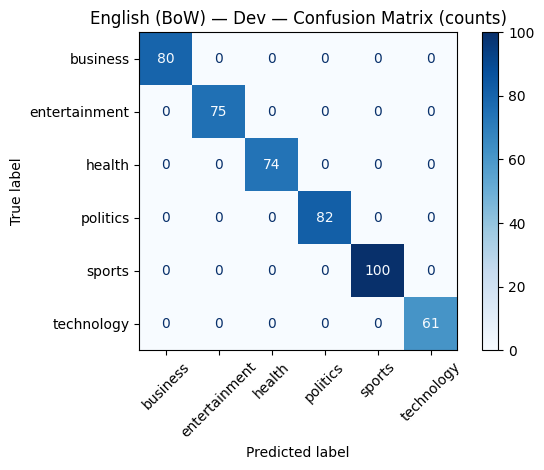

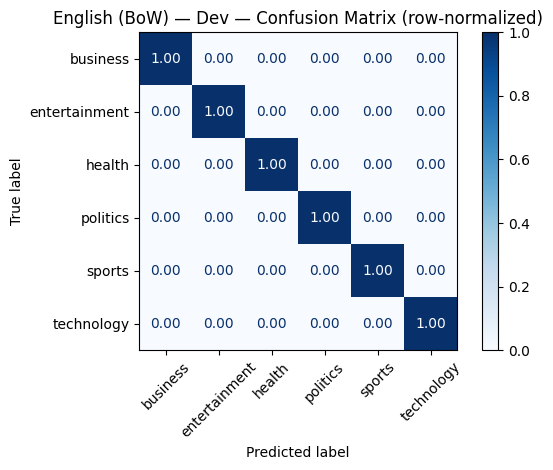


=== isiXhosa (BoW) — Dev — Overall Metrics ===
Accuracy      : 1.0000
Precision (µ) : 1.0000   Recall (µ): 1.0000   F1 (µ): 1.0000
Precision (M) : 1.0000   Recall (M): 1.0000   F1 (M): 1.0000

Per-class report:
               precision    recall  f1-score   support

     business     1.0000    1.0000    1.0000         7
entertainment     1.0000    1.0000    1.0000        50
       health     1.0000    1.0000    1.0000        10
     politics     1.0000    1.0000    1.0000        31
       sports     1.0000    1.0000    1.0000        49

     accuracy                         1.0000       147
    macro avg     1.0000    1.0000    1.0000       147
 weighted avg     1.0000    1.0000    1.0000       147



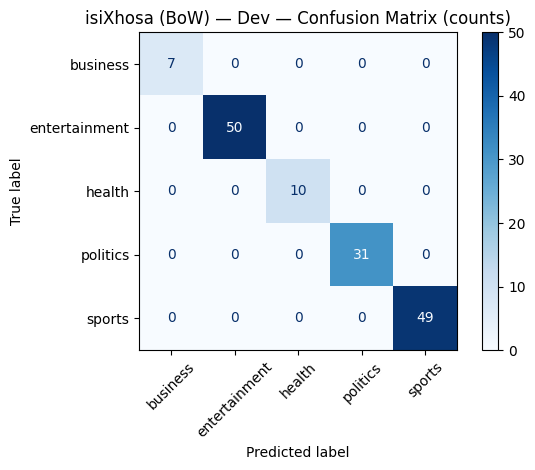

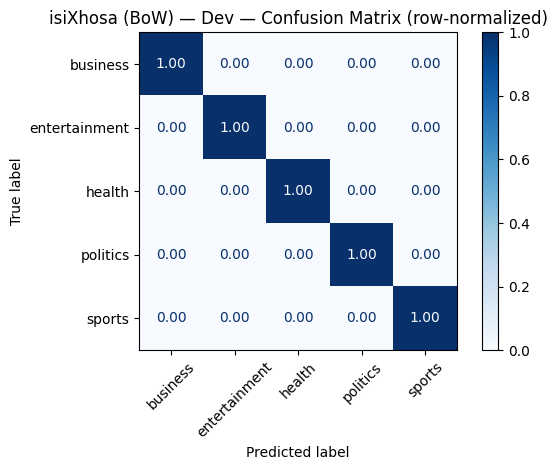


=== English — BoW (lr=0.01, bs=256, epochs=30, wd=1e-4) — Overall Metrics ===
Accuracy      : 0.8966
Precision (µ) : 0.8966   Recall (µ): 0.8966   F1 (µ): 0.8966
Precision (M) : 0.8951   Recall (M): 0.8922   F1 (M): 0.8927

Per-class report:
               precision    recall  f1-score   support

     business     0.9301    0.8313    0.8779       160
entertainment     0.8929    0.8333    0.8621       150
       health     0.9073    0.9133    0.9103       150
     politics     0.8596    0.9273    0.8921       165
       sports     0.9238    0.9700    0.9463       200
   technology     0.8571    0.8780    0.8675       123

     accuracy                         0.8966       948
    macro avg     0.8951    0.8922    0.8927       948
 weighted avg     0.8975    0.8966    0.8961       948



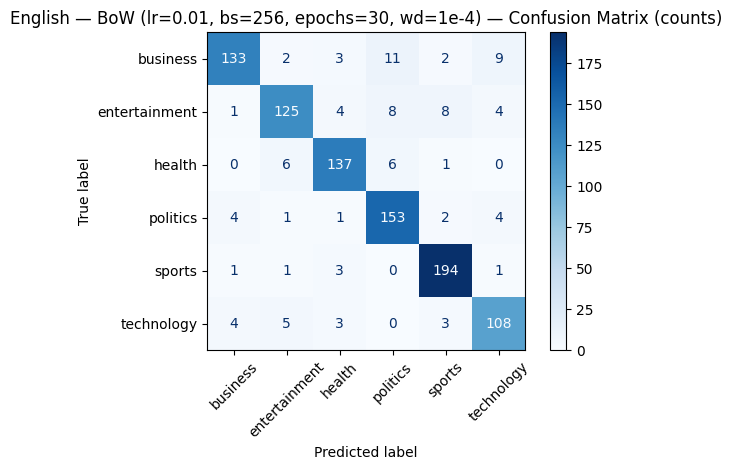

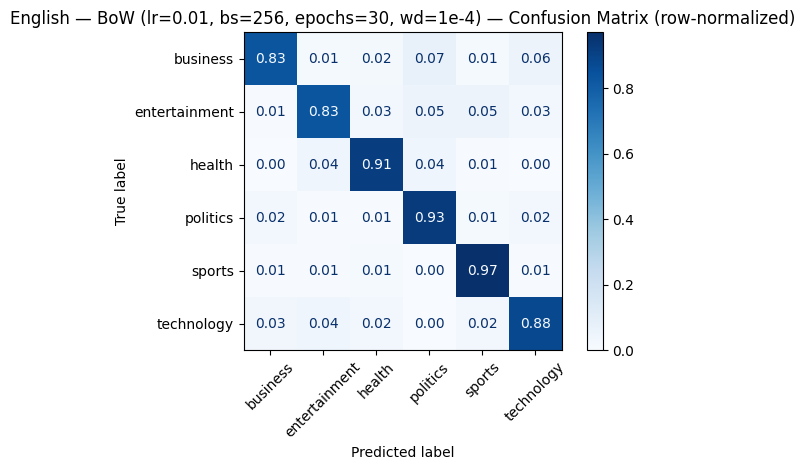


=== isiXhosa — BoW (lr=0.01, bs=256, epochs=40, wd=0) — Overall Metrics ===
Accuracy      : 0.9293
Precision (µ) : 0.9293   Recall (µ): 0.9293   F1 (µ): 0.9293
Precision (M) : 0.9197   Recall (M): 0.8100   F1 (M): 0.8444

Per-class report:
               precision    recall  f1-score   support

     business     1.0000    0.6000    0.7500        15
entertainment     0.9600    0.9600    0.9600       100
       health     0.8333    0.5000    0.6250        20
     politics     0.8052    1.0000    0.8921        62
       sports     1.0000    0.9900    0.9950       100

     accuracy                         0.9293       297
    macro avg     0.9197    0.8100    0.8444       297
 weighted avg     0.9346    0.9293    0.9244       297



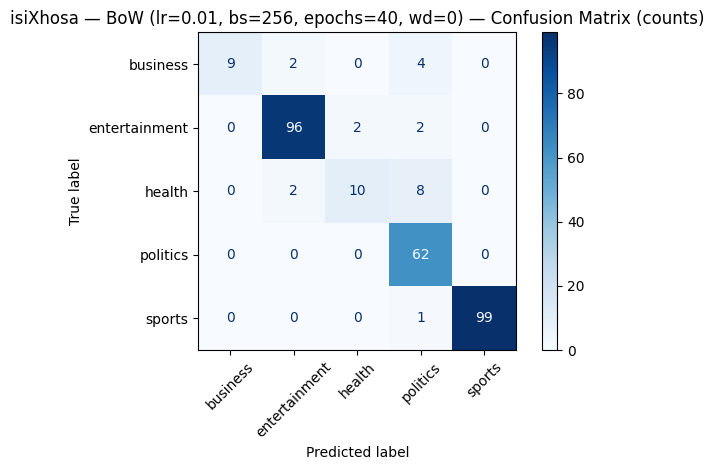

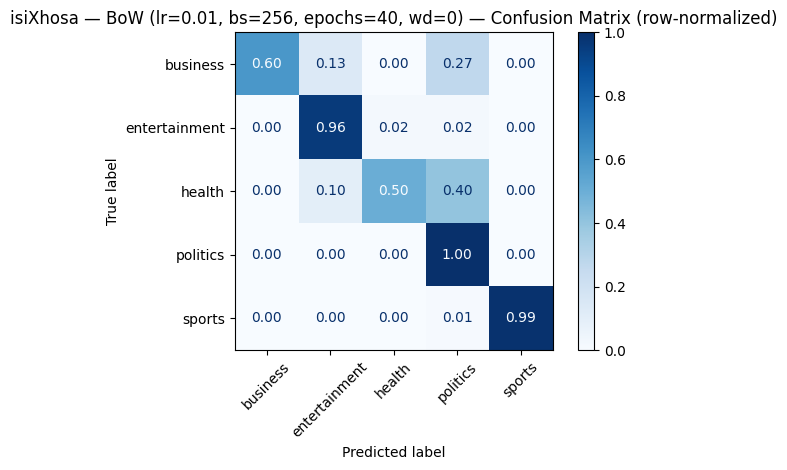

In [92]:
#validation set for english
#note that these are pointless since theyve been trained on this data 
Xdv_en_t, ydv_en_t = to_tensors(Xdv_en_unused, ydv_en_unused, device=device)
evaluate_on_test(model_en, Xdv_en_t, ydv_en_t, le_en, title="English (BoW) — Dev")

#validation set for isiXhosa
Xdv_xh_t, ydv_xh_t = to_tensors(Xdv_xh_unused, ydv_xh_unused, device=device)
evaluate_on_test(model_xh, Xdv_xh_t, ydv_xh_t, le_xh, title="isiXhosa (BoW) — Dev")


# English — BoW (best)
_ = evaluate_on_test(
    model_en, Xte_en_t, yte_en_t, le_en,
    title="English — BoW (lr=0.01, bs=256, epochs=30, wd=1e-4)"
)

# isiXhosa — BoW (best)
_ = evaluate_on_test(
    model_xh, Xte_xh_t, yte_xh_t, le_xh,
    title="isiXhosa — BoW (lr=0.01, bs=256, epochs=40, wd=0)"
)


In [89]:
#Question 8 analyzing weights
import numpy as np
import pandas as pd
import torch

def analyze_softmax_weights(model, vectorizer, label_encoder, top_k=15, contrasted=True):

    #pull bias
    W = model.linear.weight.detach().cpu().numpy()   # [C, D]
    b = model.linear.bias.detach().cpu().numpy() if model.linear.bias is not None else None
    classes = list(label_encoder.classes_)
    
    #map feature index -> token
    try:
        feats = vectorizer.get_feature_names_out()
    except AttributeError:
        feats = vectorizer.get_feature_names()  # older sklearn
    D = len(feats)

    # 3) optionally contrast each class against the mean of others
    if contrasted:
        Wc = np.empty_like(W)
        for c in range(W.shape[0]):
            others = np.delete(W, c, axis=0)
            Wc[c] = W[c] - others.mean(axis=0)
        W_to_show = Wc
    else:
        W_to_show = W

    #display top-k positive and negative weights per class
    for c, cname in enumerate(classes):
        w = W_to_show[c]
        top_pos_idx = np.argsort(w)[-top_k:][::-1]
        top_neg_idx = np.argsort(w)[:top_k]  # least (most negative) if you want to see anti-features

        print(f"\n=== Class: {cname} ===")
        if b is not None:
            print(f"bias (prior tilt): {b[c]:.4f}")
        print("Top +weights:")
        for j in top_pos_idx:
            print(f"  {feats[j]:<20s}  {w[j]: .4f}")
        print("Top -weights (push away):")
        for j in top_neg_idx:
            print(f"  {feats[j]:<20s}  {w[j]: .4f}")

    # 5) globally most influential features (any class)
    max_abs = np.max(np.abs(W_to_show), axis=0)
    top_global = np.argsort(max_abs)[-top_k:][::-1]
    print("\n=== Tokens with largest absolute influence (any class) ===")
    for j in top_global:
        # show which class uses it most
        c_star = np.argmax(np.abs(W_to_show[:, j]))
        print(f"  {feats[j]:<20s}  |class={classes[c_star]:<12s}  weight={W_to_show[c_star, j]: .4f}")


In [90]:
#Question 8
analyze_softmax_weights(model_en, vec_en, le_en, top_k=15, contrasted=True)



=== Class: business ===
bias (prior tilt): -0.3258
Top +weights:
  secrets                0.5057
  boss                   0.5052
  pcs                    0.4781
  founded                0.4695
  business               0.4608
  finances               0.4100
  ceo                    0.4098
  sorry                  0.3863
  shares                 0.3813
  beauty                 0.3810
  rease                  0.3677
  turn                   0.3539
  loan                   0.3524
  passing                0.3317
  incredibly             0.3254
Top -weights (push away):
  iain                  -0.4038
  sorting               -0.3552
  houston               -0.3429
  griffin               -0.3359
  rapper                -0.3203
  app                   -0.3036
  stewart               -0.2900
  producer              -0.2831
  2023                  -0.2749
  duo                   -0.2736
  founders              -0.2734
  rachel                -0.2699
  read                  -0.2674
  secret    